In [2]:
!pip install -U pip
!pip install -U nltk==3.8.1
!pip install tqdm

In [3]:
import nltk
nltk.download('punkt')
nltk.download('lm')  # Tải thư viện language model của NLTK

# Tải dữ liệu và giải nén - giữ nguyên code cũ
!wget https://github.com/hoanganhpham1006/Vietnamese_Language_Model/raw/master/Train_Full.zip
!unzip /content/Train_Full.zip

# Đọc dữ liệu - giữ nguyên code cũ
import os

full = []
for dirname, _, filenames in os.walk('/content/Train_Full'):
    for filename in filenames:
        with open(os.path.join("/content", os.path.join(dirname, filename)), 'r', encoding='UTF-16') as f:
            full.append(f.read())

print(f"Đã đọc {len(full)} file văn bản")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Error loading lm: Package 'lm' not found in index


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Train_Full/Van hoa/VH_TN_T_ (11395).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11396).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11398).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11399).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11400).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11401).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11405).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11412).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11413).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11414).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11415).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11417).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11418).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11419).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11421).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11423).txt  
  inflating: Train_Full/Van hoa/VH_TN_T_ (11425).txt  
  inflat

In [4]:
import re
from nltk import word_tokenize
import string
from tqdm import tqdm

def tokenize(doc):
    tokens = word_tokenize(doc.lower())
    table = str.maketrans('', '', string.punctuation.replace("_", ""))
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word]
    return tokens

full_data = ". ".join(full)
full_data = full_data.replace("\n", ". ")
corpus = []
sents = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', full_data)
for sent in tqdm(sents):
    corpus.append(tokenize(sent))

print(f"Số lượng câu: {len(corpus)}")

100%|██████████| 738597/738597 [03:18<00:00, 3712.73it/s]

Số lượng câu: 738597


In [8]:
import re

def remove_vn_accent(word):
    word = re.sub('[áàảãạăắằẳẵặâấầẩẫậ]', 'a', word)
    word = re.sub('[éèẻẽẹêếềểễệ]', 'e', word)
    word = re.sub('[óòỏõọôốồổỗộơớờởỡợ]', 'o', word)
    word = re.sub('[íìỉĩị]', 'i', word)
    word = re.sub('[úùủũụưứừửữự]', 'u', word)
    word = re.sub('[ýỳỷỹỵ]', 'y', word)
    word = re.sub('đ', 'd', word)
    return word

# Tải danh sách âm tiết tiếng Việt nếu chưa có
!wget -O vn_syllables.txt "https://gist.githubusercontent.com/hieuthi/0f5adb7d3f79e7fb67e0e499004bf558/raw/135a4d9716e49a981624474156d6f247b9b46f6a/all-vietnamese-syllables.txt"

def gen_accents_word(word):
    """Tạo các phiên bản có dấu khác nhau của một từ không dấu"""
    word_no_accent = remove_vn_accent(word.lower())
    all_accent_word = {word}
    for w in open('vn_syllables.txt').read().splitlines():
        w_no_accent = remove_vn_accent(w.lower())
        if w_no_accent == word_no_accent:
            all_accent_word.add(w)
    return all_accent_word

--2025-05-18 06:59:44--  https://gist.githubusercontent.com/hieuthi/0f5adb7d3f79e7fb67e0e499004bf558/raw/135a4d9716e49a981624474156d6f247b9b46f6a/all-vietnamese-syllables.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116290 (114K) [text/plain]
Saving to: ‘vn_syllables.txt’

vn_syllables.txt    100%[===================>] 113.56K  --.-KB/s    in 0.02s   

2025-05-18 06:59:44 (5.46 MB/s) - ‘vn_syllables.txt’ saved [116290/116290]



In [5]:
import pickle
import math
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import KneserNeyInterpolated
from tqdm import tqdm

# Tạo mô hình ngôn ngữ sử dụng NLTK
print("Tạo mô hình trigram NLTK...")

# Chuẩn bị dữ liệu cho mô hình ngôn ngữ
n = 3  # Trigram model
train_data, padded_vocab = padded_everygram_pipeline(n, corpus)

# Khởi tạo mô hình Kneser-Ney
model = KneserNeyInterpolated(n)

# Huấn luyện mô hình
print("Bắt đầu huấn luyện mô hình...")
model.fit(train_data, padded_vocab)
print(f"Hoàn thành huấn luyện. Kích thước từ điển: {len(model.vocab)}")

# Lưu mô hình bằng pickle
model_path = "nltk_trigram_model.pkl"
with open(model_path, 'wb') as fout:
    pickle.dump(model, fout)
print(f"Đã lưu mô hình vào {model_path}")

Tạo mô hình trigram NLTK...
Bắt đầu huấn luyện mô hình...
Hoàn thành huấn luyện. Kích thước từ điển: 104813
Đã lưu mô hình vào nltk_trigram_model.pkl


In [18]:
def beam_search_nltk(words, model, k=3):
    """
    Sử dụng Beam Search để tìm chuỗi từ có dấu với điểm số cao nhất
    sử dụng mô hình NLTK

    Args:
        words: Danh sách các từ không dấu
        model: Mô hình ngôn ngữ NLTK
        k: Số lượng lựa chọn tốt nhất giữ lại ở mỗi bước
    """
    sequences = []

    for idx, word in enumerate(words):
        if idx == 0:
            # Bước đầu tiên - tạo các phiên bản có dấu của từ đầu tiên
            sequences = [([x], 0.0) for x in gen_accents_word(word)]
        else:
            all_sequences = []

            for seq in sequences:
                # Với mỗi chuỗi hiện tại, thử tất cả các phiên bản có dấu của từ tiếp theo
                for next_word in gen_accents_word(word):
                    score = 0

                    # Lấy context tối đa 2 từ trước đó cho trigram model
                    context = seq[0][-min(2, len(seq[0])):]

                    # Tính điểm sử dụng logscore của mô hình NLTK
                    try:
                        score = model.logscore(next_word, context)
                    except (ValueError, KeyError):
                        # Xử lý trường hợp context không có trong mô hình
                        # Gán giá trị xác suất rất nhỏ
                        score = -100

                    # Tạo chuỗi mới và cập nhật điểm
                    new_seq = seq[0].copy()
                    new_seq.append(next_word)
                    all_sequences.append((new_seq, seq[1] + score))

            # Giữ lại k chuỗi có điểm cao nhất
            all_sequences = sorted(all_sequences, key=lambda x: x[1], reverse=True)
            sequences = all_sequences[:k]

    return sequences

In [19]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize

# Tải mô hình đã huấn luyện
with open("nltk_trigram_model.pkl", 'rb') as fin:
    nltk_model = pickle.load(fin)

# Thử nghiệm thêm dấu
test_sentences = [
    "toi la nguoi viet nam",
    "hom nay toi di hoc",
    "ngay hom qua la ngay bau cu tong thong My",
    "tieng viet la ngon ngu cua nguoi viet"
]

for sentence in test_sentences:
    print(f"\nCâu gốc: {sentence}")
    result = beam_search_nltk(sentence.lower().split(), nltk_model, k=3)

    print("Top 3 kết quả:")
    for i, (words, score) in enumerate(result):
        print(f"{i+1}. {detokenize(words)} (score: {score:.4f})")


Câu gốc: toi la nguoi viet nam
Top 3 kết quả:
1. tôi là người việt nam (score: -15.5484)
2. toi la nguoi viet nam (score: -20.9326)
3. tôi là người việt nắm (score: -25.2520)

Câu gốc: hom nay toi di hoc
Top 3 kết quả:
1. hòm này tôi đi học (score: -19.8163)
2. hôm nay tôi đi học (score: -20.9017)
3. hòm này tôi đi hoc (score: -23.2192)

Câu gốc: ngay hom qua la ngay bau cu tong thong My
Top 3 kết quả:
1. ngày hôm qua là ngày bầu cử tổng thống mỹ (score: -40.4381)
2. ngẫy hôm qua là ngày bầu cử tổng thống mỹ (score: -44.0740)
3. ngay hôm qua là ngày bầu cử tổng thống mỹ (score: -46.2688)

Câu gốc: tieng viet la ngon ngu cua nguoi viet
Top 3 kết quả:
1. tiếng việt là ngôn ngữ của người việt (score: -30.6379)
2. tiếng việt là ngôn ngữ của người viết (score: -33.5722)
3. tiệng việt là ngôn ngữ của người việt (score: -36.5167)


In [54]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize

test_sentence = "ngay hom qua la ngay bau cu tong thong My"

# Dự đoán từ mô hình
predictions = []

# Chạy beam search cho câu thử nghiệm
result = beam_search_nltk(test_sentence.lower().split(), model, k=3)
best_sentence = detokenize(result[0][0])
predictions.append(best_sentence)

In [55]:
# Câu tham chiếu (câu đúng có dấu)
reference = "Ngày hôm qua là ngày bầu cử tổng thống Mỹ"

# Hàm tính độ chính xác ký tự
def char_level_accuracy(pred, ref):
    correct_chars = sum(p == r for p, r in zip(pred, ref))
    return correct_chars / len(ref) if ref else 0.0

# Hàm tính độ chính xác từ
def word_level_accuracy(pred, ref):
    pred_words = pred.split()
    ref_words = ref.split()
    correct_words = sum(p == r for p, r in zip(pred_words, ref_words))
    return correct_words / len(ref_words) if ref_words else 0.0

# Câu dự đoán từ mô hình
predicted_sentence = predictions[0]  # Lấy câu dự đoán tốt nhất từ danh sách `predictions`

# Tính các chỉ số
char_acc = char_level_accuracy(predicted_sentence, reference) * 100
word_acc = word_level_accuracy(predicted_sentence, reference) * 100

# Hiển thị kết quả
print(f"Ref   : {reference}")
print(f"Pred  : {predicted_sentence}")
print(f"Character Accuracy: {char_acc:.2f}%")
print(f"Word Accuracy     : {word_acc:.2f}%")

Ref   : Ngày hôm qua là ngày bầu cử tổng thống Mỹ
Pred  : ngày hôm qua là ngày bầu cử tổng thống mỹ
Character Accuracy: 95.12%
Word Accuracy     : 80.00%


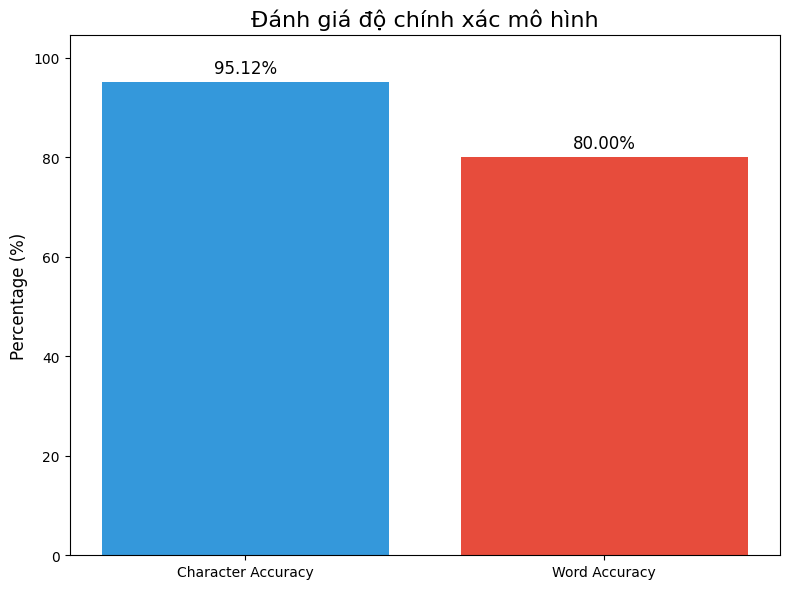

In [56]:
import matplotlib.pyplot as plt

metrics = [char_acc, word_acc]  # Giá trị thực từ biến đã tính
labels = ["Character Accuracy", "Word Accuracy"]

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, metrics, color=['#3498db', '#e74c3c'])

# Thêm giá trị trên đầu mỗi cột
for bar, metric in zip(bars, metrics):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f"{metric:.2f}%", ha='center', va='bottom', fontsize=12)

# Thiết lập tiêu đề và nhãn trục
plt.title("Đánh giá độ chính xác mô hình", fontsize=16)
plt.ylabel("Percentage (%)", fontsize=12)
plt.ylim(0, max(metrics) * 1.1)  # Tự động điều chỉnh độ cao trục y

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

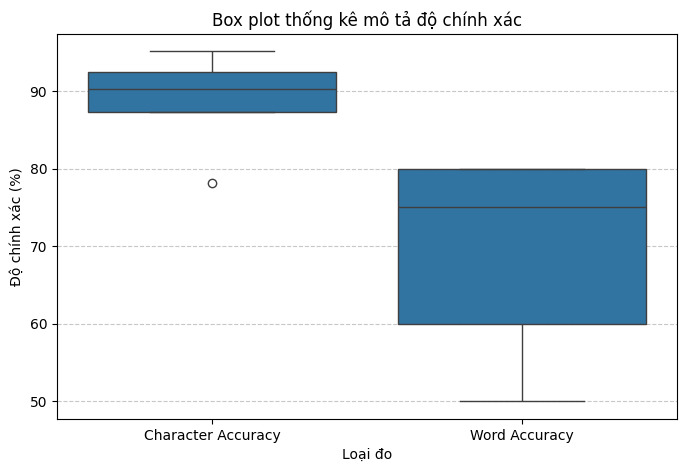

In [58]:
import pandas as pd

# Tạo DataFrame từ dữ liệu
df = pd.DataFrame({
    "Character Accuracy": char_accuracies,
    "Word Accuracy": word_accuracies
})

# Chuyển đổi sang định dạng dài (long format)
df_melted = pd.melt(df, var_name="Loại đo", value_name="Độ chính xác (%)")

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_melted, x="Loại đo", y="Độ chính xác (%)")
plt.title("Box plot thống kê mô tả độ chính xác")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

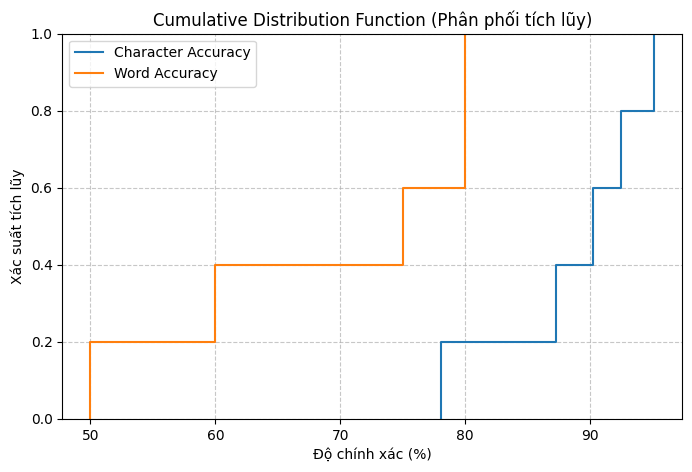

In [60]:
plt.figure(figsize=(8, 5))
sns.ecdfplot(char_accuracies, label='Character Accuracy')
sns.ecdfplot(word_accuracies, label='Word Accuracy')
plt.title("Cumulative Distribution Function (Phân phối tích lũy)")
plt.xlabel("Độ chính xác (%)")
plt.ylabel("Xác suất tích lũy")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()